# Анализ поведения пользователей мобильного приложения по продаже продуктов питания.

1. [Описание проекта](#section_id)
2. [Предобработка данных](#step_1)
    1. [Общая информация](#step_1_1)
    2. [Обработка дубликатов и переименование столбцов](#step_1_2)
3.[Изучение данных](#step_2)
4.[Анализ воронки событий](#step_3)
5.[Анализ результатов эксперимента](#step_4)
    1. [A/A тест](#step_4_1)
    2. [A/A/B тест](#step_4_2)
    3. [Поправка Бонферрони](#step_4_3)
6.[Вывод](#step_5)

<a id='section_id'></a>
## Описание проекта

Проведем анализ пользователей мобильного приложения по файлу с событиями, произведенных в мобильном приложении. 
Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


<a id='step_1'></a>
## Предобработка данных

<a id='step_1_1'></a>
### Общая информация

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
import warnings
register_matplotlib_converters()
import plotly.express as px 
from plotly import graph_objects as go
import numpy as np
import seaborn as sns
import math
import scipy.stats as stats

In [2]:
# Функция для вывода основной информации 
def df_info(df):
    df.info()
    print('Случайная выборка по данным')
    display(df.sample(n=5, random_state=1))
    print('*'*50)
    print('Первичная статистика по данным')
    display(df.describe().T)
    print('*'*50)
    print('Количество полных дубликатов:',sum(df.duplicated()))

In [3]:
#сохраняем датасет
df = pd.read_csv('C:\\Users\\User\\Documents\\DataScience\\Проекты\\Анализ пользовательского поведения в мобильном приложении\\logs_exp.csv', sep='\t')
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Случайная выборка по данным


,EventName,DeviceIDHash,EventTimestamp,ExpId
120873,MainScreenAppear,9096061512161785646,1564917596,248
4103,OffersScreenAppear,1074933668878523996,1564631437,247
92724,OffersScreenAppear,8115340604306569112,1564838447,246
128891,CartScreenAppear,3163109716415429772,1564930563,246
186942,OffersScreenAppear,2405626918155135838,1565082344,247


**************************************************
Первичная статистика по данным


,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,244126.0,4.627568e+18,2.642425e+18,6.888747e+15,2.372212e+18,4.623192e+18,6.932517e+18,9.222603e+18
EventTimestamp,244126.0,1.564914e+09,1.771343e+05,1.564030e+09,1.564757e+09,1.564919e+09,1.565075e+09,1.565213e+09
ExpId,244126.0,2.470223e+02,8.244339e-01,2.460000e+02,2.460000e+02,2.470000e+02,2.480000e+02,2.480000e+02


**************************************************
Количество полных дубликатов: 413


In [4]:
#столбец с датой отображается некорректно, заменим тип данных
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'],unit='s') 
df.head() #вывод таблицы

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


**Вывод** В таблице 244126 строк и 4 столбца с данными, тип данных у столбца с датой события уже был изменен на соответсвующий datetime, так как чтение файла без этой замены было некорректно. Явных дубликатов выявлено 413 строк, пропущенных значений нет.

<a id='step_1_2'></a>
### Обработка дубликатов и переименование столбцов

In [5]:
# удаление явных дубликатов (с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True) 
df.duplicated().sum() #проверка удаления

0

In [6]:
df = df.rename(columns = {'EventName' : 'event_name',
                          'DeviceIDHash' : 'id','EventTimestamp' : 'event_time', 'ExpId':'group'}) # переименование столбцов
df.columns #проверка переименования столбцов

Index(['event_name', 'id', 'event_time', 'group'], dtype='object')

In [7]:
#добавим отдельный столбец для дат
df['date'] = df['event_time'].dt.date
df.head()

,event_name,id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Вывод** В таблице было выявлено и удалено 413 явных дубликатов, также для удобства работы были переименованы названия столбцов и сформирован отдельный столбец  с датой проведенного события. Дубликаты могли получиться из за некорретности сбора данных или выгрузку делали несколько раз за один и тот же период 

<a id='step_2'></a>
## Изучение данных

Рассмотрим с каким количеством данных мы можем работать.

In [8]:
print('Количество событий в логе:', len(df))

Количество событий в логе: 243713


In [9]:
print('Количество пользователей в логе:', df['id'].nunique())

Количество пользователей в логе: 7551


In [10]:
df.pivot_table(index='id',values = 'event_name',aggfunc='count').describe()
#Выводим статистические значения
#по количеству событий на пользователя

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


In [11]:
df['date'].max() #максимальная дата в логе

datetime.date(2019, 8, 7)

In [12]:
df['date'].min() #минимальная дата в логе

datetime.date(2019, 7, 25)

В датафрейме хранятся результаты событий с 25 июля 2019 года по 7 августа 2019 года, это составляет ровно 14 дней, т.е. 2 недели. Рассмотрим, как распределяются события по времени

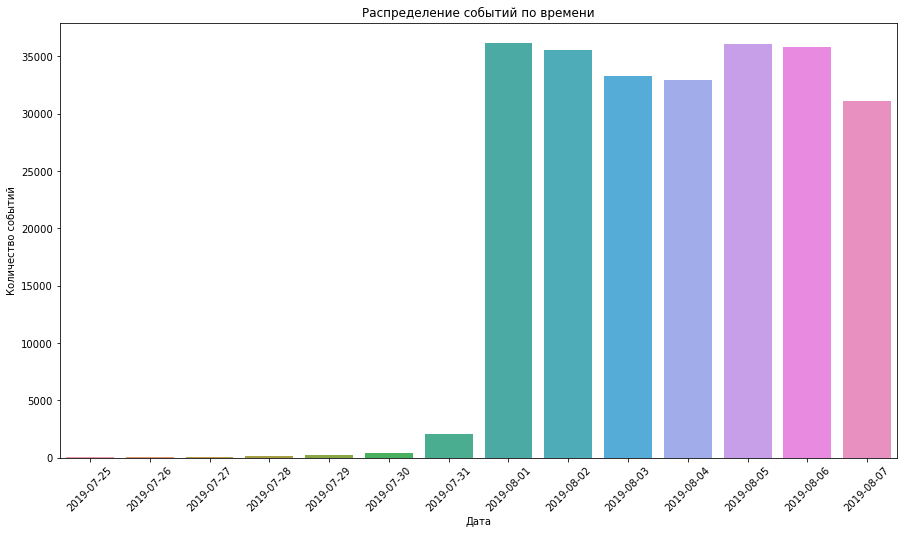

In [13]:
sns.set_palette('pastel') # задаем цветовую гамму для всех графиков
df_pivot = df.groupby('date').agg({'event_name':'count'}).reset_index(drop=False)
plt.figure(figsize = (15,8))
sns.barplot(x='date', y='event_name',data=df_pivot)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени')
plt.show()

Исходя из полученного графика мы отчетливо видим, что до 1 августа событий почти нет, т.е. мы можем считать эти данные неполными и не брать их в дальнейший анализ, так как делать какие либо выводы по первой неделе неверно и это может исказить результат ислледования.

In [14]:
df['date'] = df['date'].astype('datetime64[D]')
df_new = df.loc[df['date'] > '2019-07-31']
print('Количество событий в отфильтрованном логе:', len(df_new))
print('Удалено событий:', ( len(df) - len(df_new)))
print('Количество пользователей, которые не попали в отфильтрованный лог:', (df['id'].nunique() - df_new['id'].nunique()))
print('Доля удаленных данных:', round(( len(df) - len(df_new)) / len(df),2))

Количество событий в отфильтрованном логе: 240887
Удалено событий: 2826
Количество пользователей, которые не попали в отфильтрованный лог: 17
Доля удаленных данных: 0.01


In [15]:
#проверим из всех ли групп у нас остались пользователи
df_new.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


**Вывод** Мы более подробно изучили лог с событиями, выявили, что предоставленные данные с 25 июля по 7 августа неполные, данные с 25 по 31 июля очень малы, поэтому мы их убрали из дальнейшего анализа. Также мы определели, что в среднем на одного пользователя приходиться 32 события

<a id='step_3'></a>
## Анализ воронки событий

In [16]:
#сводная таблица по частоте событий в логе
df_new.groupby('event_name').agg({'id':'count'}).sort_values(by='id', ascending=False).style.background_gradient('coolwarm')

,id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [17]:
#сводная таблица по количеству пользователей совершавших определенное событие
df_pivot = df_new.groupby('event_name').agg({'id':'nunique'}).sort_values(by='id', ascending=False)
df_pivot['%'] = (df_pivot['id'] / df_new['id'].nunique()).round(2) #доля пользователей, которые хоть раз совершали данное событие
df_pivot.style.background_gradient('coolwarm')

,id,%
event_name,,
MainScreenAppear,7419,0.980000
OffersScreenAppear,4593,0.610000
CartScreenAppear,3734,0.500000
PaymentScreenSuccessful,3539,0.470000
Tutorial,840,0.110000


Рассмотрев наименование, частоту совершенных действий в общем и по количеству пользователей, мы видим и можем предположить,что события происходят в следующей порядке: 
* MainScreenAppear -- Главный экран
* OffersScreenAppear	 - Экран предложений/каталог
* CartScreenAppear - Экран карты
* PaymentScreenSuccessful  - Экран оплаты

Событие **Tutorial** скорее всего относиться к какому то обучающему процессу/ как пользоваться приложением и т.д. Такой маленький процент задейстованных пользователей говорит о том, что либо большинство наших пользователей с нами давно, приложение они скачали давно и обучающую часть они прошли ранее, также возможно,что у этой части события есть кнопка "Пропустить", и многие пользователи ею пользуются.
Также мы наблюдаем Отсутсвие конверсии на первом шаге воронки, это говорит нам о том, что либо не все данные предоставлены и какая-то часть потерялась, либо что пользователи каким то образом обходят первый путь и не попадают на главный экран 

,id,conversion,id_step,conversion_step
event_name,,,,
MainScreenAppear,7419,1.00,NaN,NaN
OffersScreenAppear,4593,0.62,7419.0,0.62
CartScreenAppear,3734,0.50,4593.0,0.81
PaymentScreenSuccessful,3539,0.48,3734.0,0.95


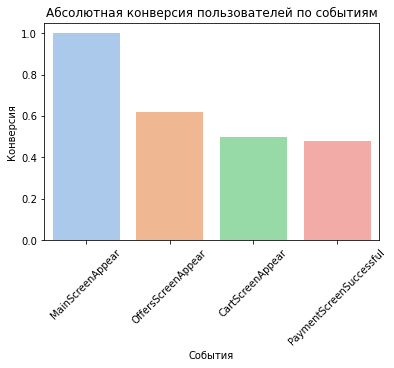

In [18]:
#построим воронку событий 
report = df_new.query('event_name != "Tutorial"').groupby('event_name').agg({'id':'nunique'}).sort_values(by='id',
                                                                                                          ascending=False)
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['id_step'] = report['id'].shift()
report['conversion_step'] = (report['id'] / report['id_step']).round(2)
display(report)
sns.barplot(x=report.index, y='conversion',data=report)
plt.xticks(rotation=45)
plt.xlabel('События')
plt.ylabel('Конверсия')
plt.title('Абсолютная конверсия пользователей по событиям')
plt.show()


По воронке мы видим, что большинство пользователей теряются между событиями Показ главного экрана - Экран каталога предложений,соответсвенно предполагаем что они открывают приложения, но не переходят на страницу с товарами и в дальнейшем не покупают товар. Рассматривая также конверсию по шагам, мы видим что большой показатель ( 82%) у покупателей, которые зашли в каталог и далее оформили заказ ( Перешли на страницу Карты), и всего 5% покупателей не дошли до окончательной покупки, такой маленький показатель врядли говорит о том, что существуют какие-либо проблемы с платежной системой. Вероятно это может быть связано с тем, что покупатель просто передумал покупать в последний момент. 

Стоит сделать акцент на большой потере пользователей между первым и вторым шагом, почему пользователь не проходит дальше главного экрана.

<a id='step_4'></a>
## Анализ результатов эксперимента

В эксперименте участвовали 3 группы
246 и 247 — контрольные группы, а 248 — экспериментальная.
Рассмотрим сколько пользователей в каждой группе:

In [19]:
df_new.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


In [20]:
df_new.groupby(['group']).agg({'id': {'nunique'}}) #подсчет уникальных пользователей в группах

,id
,nunique
group,
246,2484
247,2513
248,2537


In [21]:
#Разделим фрейм на группы
group_246 = df_new.query('group == 246')
group_247 = df_new.query('group == 247')
group_248 = df_new.query('group == 248')

In [22]:
#проверим пересечения пользователей между группами
print(len(np.intersect1d(group_246['id'], group_247['id'])))
print(len(np.intersect1d(group_246['id'], group_248['id'])))
print(len(np.intersect1d(group_247['id'], group_248['id'])))

0
0
0


<a id='step_4_1'></a>
### A/A тест

Проведем А/А тест и проверим найдут ли статистические критерии разницу между контрольными группами 246 и 247

In [23]:
#Функия для z-теста
def check_hypothesis(successes1, successes2, trials1, trials2) :
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1-p_combined) * (1/trials1 + 1/trials2) )
    distr = stats.norm (0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [24]:
group = df_new.groupby('group').agg({'id':'nunique'})
display(group)

event_pivot = df_new.pivot_table(index='event_name', columns='group', values='id',aggfunc='nunique')
event_pivot

,id
group,
246,2484
247,2513
248,2537


group,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


**H0: Между контрольными группами 246 и 247 нет отличий в доли пользователей, совершивших событие Х**

**H1: Между контрольными группами 246 и 247 есть различия в доли пользователей, совершивших событие Х**

In [25]:
alpha = 0.01
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 247],
                        group.loc[246].values[0], group.loc[247].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246 и 247 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 247],
                        group.loc[246].values[0], group.loc[247].values[0]))
    


Отличие между группами 246 и 247 по событию CartScreenAppear статиcтически незначимо, p-value =  0.22883372237997213
Отличие между группами 246 и 247 по событию MainScreenAppear статиcтически незначимо, p-value =  0.7570597232046099
Отличие между группами 246 и 247 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.2480954578522181
Отличие между группами 246 и 247 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.11456679313141849


Проведенный А/А тест показал, что статистических различий между контрольными группами 246 и 247 нет

<a id='step_4_2'></a>
### A/A/B тест

,id,%,conversion,id_step,conversion_step
event_name,,,,,
MainScreenAppear,2450,0.99,1.00,NaN,NaN
OffersScreenAppear,1542,0.62,0.63,2450.0,0.63
CartScreenAppear,1266,0.51,0.52,1542.0,0.82
PaymentScreenSuccessful,1200,0.48,0.49,1266.0,0.95
Tutorial,278,0.11,0.11,1200.0,0.23


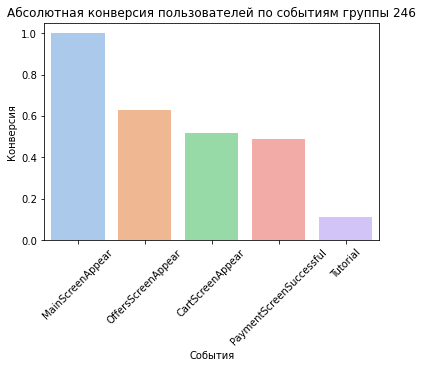

In [26]:
#построим воронки событий по отдельным группам

report = group_246.groupby('event_name').agg({'id':'nunique'}).sort_values(by='id',ascending=False)
report['%'] = (report['id'] / group_246['id'].nunique()).round(2) #доля пользователей, которые хоть раз совершали данное событие
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['id_step'] = report['id'].shift()
report['conversion_step'] = (report['id'] / report['id_step']).round(2)
display(report)
sns.barplot(x=report.index, y='conversion',data=report)
plt.xticks(rotation=45)
plt.xlabel('События')
plt.ylabel('Конверсия')
plt.title('Абсолютная конверсия пользователей по событиям группы 246')
plt.show()

,id,%,conversion,id_step,conversion_step
event_name,,,,,
MainScreenAppear,2476,0.99,1.00,NaN,NaN
OffersScreenAppear,1520,0.60,0.61,2476.0,0.61
CartScreenAppear,1238,0.49,0.50,1520.0,0.81
PaymentScreenSuccessful,1158,0.46,0.47,1238.0,0.94
Tutorial,283,0.11,0.11,1158.0,0.24


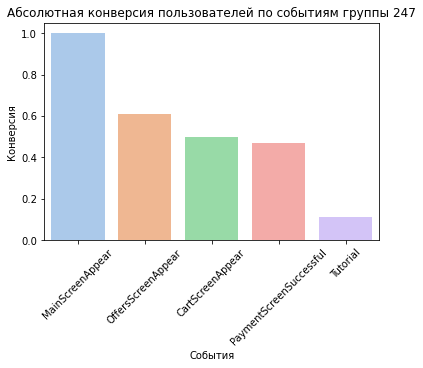

In [27]:
report = group_247.groupby('event_name').agg({'id':'nunique'}).sort_values(by='id',ascending=False)
report['%'] = (report['id'] / group_247['id'].nunique()).round(2) #доля пользователей, которые хоть раз совершали данное событие
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['id_step'] = report['id'].shift()
report['conversion_step'] = (report['id'] / report['id_step']).round(2)
display(report)
sns.barplot(x=report.index, y='conversion',data=report)
plt.xticks(rotation=45)
plt.xlabel('События')
plt.ylabel('Конверсия')
plt.title('Абсолютная конверсия пользователей по событиям группы 247')
plt.show()

,id,%,conversion,id_step,conversion_step
event_name,,,,,
MainScreenAppear,2493,0.98,1.00,NaN,NaN
OffersScreenAppear,1531,0.60,0.61,2493.0,0.61
CartScreenAppear,1230,0.48,0.49,1531.0,0.80
PaymentScreenSuccessful,1181,0.47,0.47,1230.0,0.96
Tutorial,279,0.11,0.11,1181.0,0.24


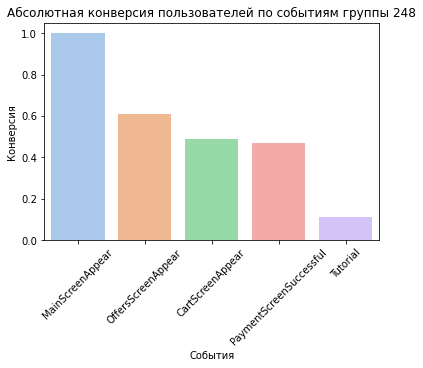

In [28]:
report = group_248.groupby('event_name').agg({'id':'nunique'}).sort_values(by='id',ascending=False)
report['%'] = (report['id'] / group_248['id'].nunique()).round(2) #доля пользователей, которые хоть раз совершали данное событие
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['conversion'] = (report['id'] / report['id'].values[0]).round(2)
report['id_step'] = report['id'].shift()
report['conversion_step'] = (report['id'] / report['id_step']).round(2)
display(report)
sns.barplot(x=report.index, y='conversion',data=report)
plt.xticks(rotation=45)
plt.xlabel('События')
plt.ylabel('Конверсия')
plt.title('Абсолютная конверсия пользователей по событиям группы 248')
plt.show()

**H0: Изменение дизайна не повлияло на конверсию и между группами нет отличий в доли пользователей, совершивших событие Х**

**H1: Изменение дизайна повлияло на коверсию,есть различия в доли пользователей, совершивших событие Х**

In [29]:
#Сделаем z-тест контрольных групп и эксперементальной
alpha = 0.05
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 248],
                        group.loc[246].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 248],
                        group.loc[246].values[0], group.loc[248].values[0]))

Отличие между группами 246 и 248 по событию CartScreenAppear статиcтически незначимо, p-value =  0.07842923237520116
Отличие между группами 246 и 248 по событию MainScreenAppear статиcтически незначимо, p-value =  0.2949721933554552
Отличие между группами 246 и 248 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.20836205402738917
Отличие между группами 246 и 248 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.2122553275697796


In [30]:
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 247], event_pivot.loc[event_name, 248],
                        group.loc[247].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 247 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 247], event_pivot.loc[event_name, 248],
                        group.loc[247].values[0], group.loc[248].values[0]))

Отличие между группами 247 и 248 по событию CartScreenAppear статиcтически незначимо, p-value =  0.5786197879539783
Отличие между группами 247 и 248 по событию MainScreenAppear статиcтически незначимо, p-value =  0.4587053616621515
Отличие между группами 247 и 248 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.9197817830592261
Отличие между группами 247 и 248 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.7373415053803964


In [31]:
#сравним эксперементальную группу с объедененной 246 и 247 группами
#формируем объединенную группу
comb = df_new.query('group in [246,247]')
comb['group'] = '246 + 247'
#соединяем с основной таблицей
df_comb = df_new.append(comb)
#воронка
group_new = df_comb.groupby('group').agg({'id':'nunique'})
display(group_new)

event_pivot_new = df_comb.pivot_table(index='event_name', columns='group', values='id',aggfunc='nunique')
event_pivot_new

,id
group,
246,2484
247,2513
248,2537
246 + 247,4997


group,246,247,248,246 + 247
event_name,,,,
CartScreenAppear,1266,1238,1230,2504
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [32]:
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot_new.loc[event_name, '246 + 247'], event_pivot.loc[event_name, 248],
                        group_new.loc['246 + 247'].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246+247 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis (event_pivot_new.loc[event_name, '246 + 247'], event_pivot.loc[event_name, 248],
                        group_new.loc['246 + 247'].values[0], group.loc[248].values[0]))


Отличие между группами 246+247 и 248 по событию CartScreenAppear статиcтически незначимо, p-value =  0.18175875284404386
Отличие между группами 246+247 и 248 по событию MainScreenAppear статиcтически незначимо, p-value =  0.29424526837179577
Отличие между группами 246+247 и 248 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.43425549655188256
Отличие между группами 246+247 и 248 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.6004294282308704


**Вывод** Результаты А/В теста показали, что никаких различий между контрольными и экперементальной группы не найдено. Мы провели 16 анализов, 4 А/А теста при уровне значимости 0,01% и  12 А/В тестов при уровне значимости 0,05%. За счет большого количества тестов, вероятность ошибки первого рода увеличивается, для более точного результата необходимо сделать поправку Бонферрони и проверить данные заново.

<a id='step_4_3'></a>
### Поправка Бонферрони 

In [33]:

#проводим А/А тест
alpha = 0.01
bonferroni_alpha = alpha / 16  # произведено шестнадцать сравнений
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 247],
                        group.loc[246].values[0], group.loc[247].values[0]) < bonferroni_alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246 и 247 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 247],
                        group.loc[246].values[0], group.loc[247].values[0]))
    
#Сделаем z-тест контрольных групп и эксперементальной
alpha = 0.05
bonferroni_alpha = alpha / 16  # произведено шестнадцать сравнений
#246 и 248 сравнение
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 248],
                        group.loc[246].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 246], event_pivot.loc[event_name, 248],
                        group.loc[246].values[0], group.loc[248].values[0]))
#247 и 248 сравнение 
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot.loc[event_name, 247], event_pivot.loc[event_name, 248],
                        group.loc[247].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 247 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis ( event_pivot.loc[event_name, 247], event_pivot.loc[event_name, 248],
                        group.loc[247].values[0], group.loc[248].values[0]))
#246+247 и 248 сравнение    
for event_name in ['CartScreenAppear','MainScreenAppear','OffersScreenAppear','PaymentScreenSuccessful']:
    if check_hypothesis ( event_pivot_new.loc[event_name, '246 + 247'], event_pivot.loc[event_name, 248],
                        group_new.loc['246 + 247'].values[0], group.loc[248].values[0]) < alpha:
        trig ='значимо'
    else:
        trig = 'незначимо'
    print(f'Отличие между группами 246+247 и 248 по событию {event_name} статиcтически {trig}, p-value = ',
         check_hypothesis (event_pivot_new.loc[event_name, '246 + 247'], event_pivot.loc[event_name, 248],
                        group_new.loc['246 + 247'].values[0], group.loc[248].values[0]))

Отличие между группами 246 и 247 по событию CartScreenAppear статиcтически незначимо, p-value =  0.22883372237997213
Отличие между группами 246 и 247 по событию MainScreenAppear статиcтически незначимо, p-value =  0.7570597232046099
Отличие между группами 246 и 247 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.2480954578522181
Отличие между группами 246 и 247 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.11456679313141849
Отличие между группами 246 и 248 по событию CartScreenAppear статиcтически незначимо, p-value =  0.07842923237520116
Отличие между группами 246 и 248 по событию MainScreenAppear статиcтически незначимо, p-value =  0.2949721933554552
Отличие между группами 246 и 248 по событию OffersScreenAppear статиcтически незначимо, p-value =  0.20836205402738917
Отличие между группами 246 и 248 по событию PaymentScreenSuccessful статиcтически незначимо, p-value =  0.2122553275697796
Отличие между группами 247 и 248 по событию CartSc

**Вывод** Поправка Бенферрони ситуацию не изменила, никаких различий между группами нет.

<a id='step_5'></a>
## Вывод

В процессе предобработке данных в логе было обнаружено 413 явных дубликатов, так как каждая запись сопровождается временем, вплоть до секунд, совершить два действия за одну секунду не представлавляется возможным, также это могло произойти так как,данные доходили и сохранялись некорректно. В любом случае оба эти фактора ставят под сомнения эти данные, поэтому они были удалены. Столбец с информацией по времени, был переведен в тип datetime, так как показывал время в секундах, также для удобства работы мы вывили дату в отдельный столбец.

Изучив данные, мы определили, что в логе находятся результаты событий с 25 июля 2019 года по 7 августа 2019 года, это составляет ровно 14 дней, т.е. 2 недели. Рассмотрев, как распределяются события по времени увидели, что данные первой недели( с 25 по 31 июля) не полные, вероятно в эту неделю была настройка проведения теста и не все данные записывались корректно, этот момент необходимо уточнить у разработчиков.  

Рассмотрев наименование событий, частоту совершенных действий в общем и по количеству пользователей, мы видим и можем предположить,что события происходят в следующей порядке: 
* MainScreenAppear -- Главный экран
* OffersScreenAppear	 - Экран предложений/каталог
* CartScreenAppear - Экран карты
* PaymentScreenSuccessful  - Экран оплаты

Событие **Tutorial** скорее всего относиться к какому то обучающему процессу/ как пользоваться приложением и т.д. Это событие имеет очень маленький процент частоты(всего 11% пользователей). Такой маленький процент задейстованных пользователей говорит о том, что либо большинство наших пользователей с нами давно, приложение они скачали давно и обучающую часть они прошли ранее, также возможно,что у этой части события есть кнопка "Пропустить", и многие пользователи ею пользуются.

В среднем на одного пользователя приходиться 32 события, этот показатель достаточно высокий. Предположив, что пользователь за раз перемещался несколько с главного экрана на экран каталога, и только после проводил оплату, 32 события врядли наберется. Поэтому можно предположить, что пользователи в течении недели делают по несколько заказов. Что означает, что они снова и снова возвращаются к нам в приложение.

Анализ воронки событий показал, что наиболее популярное событие - это показ главного экрана, и что самое важное большая часть покупателей отваливается между первым и вторым шагом ( Главный экран - Экран каталога), на этом шаге мы теряем 38% пользователей. Абсолютная конверсия до шага с оплатой составляет 48%, это хороший показатель, такая разница говорит нам о том, что почти все пользователи, которые дошли до каталога - оплачивают заказ.

Проанализировав результаты контрольных и эксперементальных групп, мы выявили что различий в воронке конверсий в группах не было найдено, все группы показывали примерно одинаковый результат. Из чего следует, что внедрение нового шрифта в мобильное приложение не ухудшило, но и не улучшило ситуацию. Необходимо более тщательно рассмотреть причину, потери покупателей между переходом с главного экрана на экран предложений.